# Breast Cancer Diagnosis - pipeline PCA

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

## 1. Carga y Preparación de Datos

In [2]:
print("Cargando y preparando los datos de Cáncer de Mama...")
cancer = load_breast_cancer()

data = cancer.data
labels = cancer.target

feature_names = cancer.feature_names
target_names = cancer.target_names

Cargando y preparando los datos de Cáncer de Mama...


NO VAMOS A ESTANDARIZAR LOS DATOS AÚN. Dejaremos que el Pipeline se encargue de esto por nosotros.

In [3]:
print(f"Número de muestras: {data.shape[0]}, Número de características: {data.shape[1]}")

Número de muestras: 569, Número de características: 30


## 2. Análisis Visual (Exploración)

Para la exploración inicial, está bien estandarizar primero para ver los gráficos, sobre todo de la varianza

In [4]:
X_std_explore = StandardScaler().fit_transform(data)
pca_explore = PCA(n_components=None)
pca_explore.fit(X_std_explore)
explained_variance_acum = np.cumsum(pca_explore.explained_variance_ratio_)

Graficar la Varianza Explicada (Scree Plot)

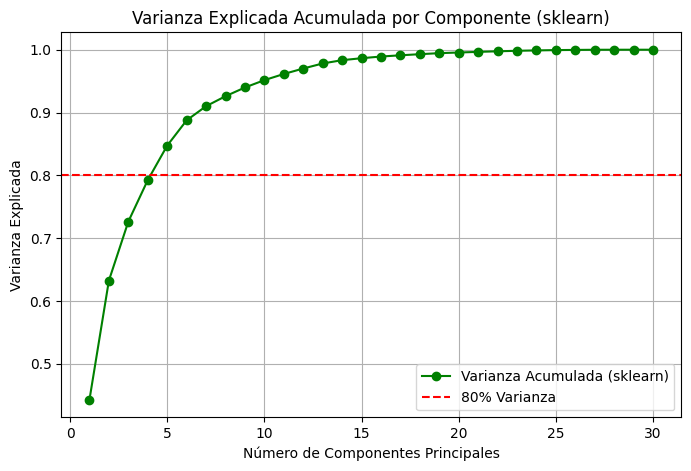

Se necesitan 5 componentes para explicar el 80% de la varianza.


In [5]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_acum) + 1), explained_variance_acum, '-o', label='Varianza Acumulada (sklearn)', color='green')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Varianza')
plt.title('Varianza Explicada Acumulada por Componente (sklearn)')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.legend()
plt.grid(True)
plt.show()

n_components_80 = np.where(explained_variance_acum >= 0.80)[0][0] + 1
print(f"Se necesitan {n_components_80} componentes para explicar el 80% de la varianza.")

## 3. Aplicación Práctica con Pipeline y GridSearchCV

In [6]:
# Dividimos los datos CRUDOS
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

### Modelo 1: Pipeline SIN PCA (Línea Base)
Creamos un pipeline que solo Estandariza y luego aplica Regresión Logística

In [7]:
pipe_full = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])

Usamos cross_val_score para una evaluación robusta en el set de entrenamiento


In [8]:
scores_full = cross_val_score(pipe_full, X_train, y_train, cv=5, scoring='accuracy')
print(f"Precisión media (CV=5) con 30 características: {np.mean(scores_full):.4f}")

Precisión media (CV=5) con 30 características: 0.9748


### Modelo 2: Pipeline CON PCA y Búsqueda de Hiperparámetros

In [9]:
# Creamos un pipeline que Estandariza, aplica PCA y luego Regresión Logística
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('model', LogisticRegression(max_iter=1000))
])

Definimos los parámetros que queremos probar. Queremos que GridSearchCV pruebe cuántos componentes (pca__n_components) son óptimos

In [10]:
param_grid = {
    'pca__n_components': [2, 3, 5, 7, 10, 15, 20]
}

print("\nEntrenando Modelo 2 (buscando los mejores componentes principales)...")
# GridSearchCV usará cross-validation (cv=5) para probar cada valor en param_grid
grid_search = GridSearchCV(pipe_pca, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Mejor número de componentes encontrado: {grid_search.best_params_['pca__n_components']}")
print(f"Precisión media (CV=5) con PCA optimizado: {grid_search.best_score_:.4f}")


Entrenando Modelo 2 (buscando los mejores componentes principales)...
Mejor número de componentes encontrado: 15
Precisión media (CV=5) con PCA optimizado: 0.9748


## 4. Evaluación Final y Conclusión

In [11]:
print(f"Redujimos el número de características de {data.shape[1]} a solo {grid_search.best_params_['pca__n_components']}.")
print(f"La diferencia en precisión fue de solo {(np.mean(scores_full) - grid_search.best_score_):.4f}.")
print("¡El PCA nos permitió reducir la complejidad del modelo casi sin perder rendimiento!")

Redujimos el número de características de 30 a solo 15.
La diferencia en precisión fue de solo 0.0000.
¡El PCA nos permitió reducir la complejidad del modelo casi sin perder rendimiento!


### Evaluación Final en el Set de Prueba (Hold-out)
Evaluación Final en el set de prueba (datos nunca vistos)

In [12]:
# Modelo 1 (Full)
pipe_full.fit(X_train, y_train)
preds_full_test = pipe_full.predict(X_test)
acc_full_test = accuracy_score(y_test, preds_full_test)
print(f"Precisión final del Modelo Full: {acc_full_test:.4f}")

Precisión final del Modelo Full: 0.9825


In [13]:
# Modelo 2 (PCA optimizado)
# (grid_search.best_estimator_ ya está entrenado con los mejores parámetros)
preds_pca_test = grid_search.best_estimator_.predict(X_test)
acc_pca_test = accuracy_score(y_test, preds_pca_test)
print(f"Precisión final del Modelo PCA: {acc_pca_test:.4f}")

Precisión final del Modelo PCA: 0.9883
